In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, matplotlib as mpl, matplotlib.ticker as ticker
import seaborn as sns
import pystore
import time
import cma
import itertools

sns.set_style('white')
mpl.rcParams['savefig.dpi'] = 300
%matplotlib inline

In [2]:
def calc_weighted_returns(returns, weights):
    weighted_returns = returns.multiply(weights).sum(axis=1)
    return weighted_returns

def calc_ghpr(returns):
    returns_array = np.array(returns)
    twr = np.product(1 + returns_array)
    ghpr = twr ** (1 / len(returns_array)) - 1
    return ghpr

# Two Uncorrelated Coins

## Helper Functions

In [3]:
def calc_weighted_returns(returns, weights):
    weighted_returns = returns.multiply(weights).sum(axis=1)
    return weighted_returns

def calc_ghpr(returns):
    returns_array = np.array(returns)
    twr = np.product(1 + returns_array)
    ghpr = twr ** (1 / len(returns_array)) - 1
    return ghpr

def get_worst_losses(returns):
    worst_losses = np.min(returns, axis=0)
    abs_worst = np.abs(worst_losses)
    return np.array(abs_worst)

def weight_combinations(returns, steps=100, bound_factor=1):
    num_components = returns.shape[1]
    worst_losses = get_worst_losses(returns)
    potential_weights = np.linspace(0, 1, steps+1)[:-1]
    weights_list = [list(potential_weights)] * num_components
    combos = list(itertools.product(*weights_list))
    combos_array = np.array(combos)
    loss_bound = np.multiply(worst_losses, bound_factor)
    norm_combos = np.divide(combos_array, loss_bound)
    return norm_combos

def f_multiple_returns(returns):
    strategies = returns.columns
    potential_weights = weight_combinations(returns)
    f_curve = pd.DataFrame()
    for i in range(len(potential_weights)):
        weights = potential_weights[i]
        weighted_returns = calc_weighted_returns(returns, weights)
        ghpr = calc_ghpr(weighted_returns)
        for j in range(len(strategies)):
            f_curve.loc[i, strategies[j]] = weights[j]        
        f_curve.loc[i, 'ghpr'] = ghpr
    optimal_f = f_curve.loc[f_curve['ghpr'].idxmax()]
    return {'f_curve':f_curve, 'optimal_f':optimal_f}

## Non-Correlated Coins

In [4]:
two_coins = pd.DataFrame({'coin 1':np.array([2,2,-1,-1]), 'coin 2':np.array([2,-1,2,-1])})
two_coins.index = np.arange(1,5)
two_coins.index.name = 'Scenario'
two_coins

,coin 1,coin 2
Scenario,,
1,2,2
2,2,-1
3,-1,2
4,-1,-1


In [5]:
f_two_coins = f_multiple_returns(two_coins)
f_two_coins['optimal_f']

/Users/bblandin/anaconda3/envs/crypto/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


coin 1    0.230000
coin 2    0.230000
ghpr      0.119119
Name: 2323, dtype: float64

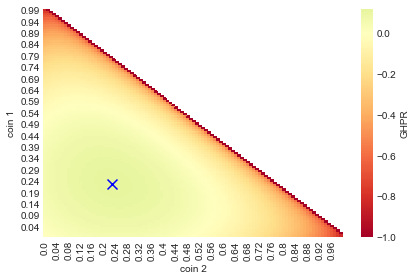

In [6]:
fig, ax = plt.subplots()
optimal_idx = f_two_coins['f_curve']['ghpr'].idxmax()
optimal_weights = f_two_coins['f_curve'].loc[optimal_idx, ['coin 1', 'coin 2']]
pivoted = pd.pivot_table(f_two_coins['f_curve'], values='ghpr', index='coin 1', columns='coin 2')
pivoted.sort_index(ascending=False, inplace=True)
pivoted.index = np.round(pivoted.index, 2)
pivoted.columns = np.round(pivoted.columns, 2)
sns.heatmap(pivoted, cmap='RdYlGn', center=0, ax=ax, cbar_kws={'label':'GHPR'})

# xvals = ax.get_xticklabels()
# ax.set_xticklabels(['{:,.2f}'.format(float(x)) for x in xvals])
# yvals = ax.get_yticklabels()
# ax.set_yticklabels(['{:,.2f}'.format(float(x)) for x in yvals])

# ax.imshow(pivoted)
# ax.scatter(optimal_weights[0], optimal_weights[1], marker='x', c='r')
ax.scatter(optimal_weights[0]*100, (1 - optimal_weights[1])*100, marker='x', c='b', s=100)
fig.tight_layout()
fig.savefig('Two Coins Heatmap')

In [7]:
results = f_two_coins['optimal_f'].to_frame()
results.columns = ['']
print(results)

                
coin 1  0.230000
coin 2  0.230000
ghpr    0.119119


## Positively Correlated Coins

In [8]:
two_coins_corr = pd.DataFrame([[2,2], [-1,-1]], columns=['Coin 1', 'Coin 2'])
two_coins_corr.index = np.arange(1,3)
two_coins_corr.index.name = 'Scenario'
two_coins_corr

,Coin 1,Coin 2
Scenario,,
1,2,2
2,-1,-1


In [9]:
f_two_coins_corr = f_multiple_returns(two_coins_corr)
results_corr = f_two_coins_corr['optimal_f'].to_frame()
results_corr.columns = ['']
print(results_corr)

/Users/bblandin/anaconda3/envs/crypto/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


               
Coin 1  0.00000
Coin 2  0.25000
ghpr    0.06066


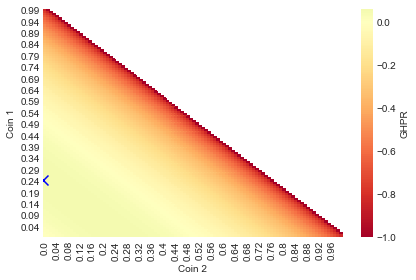

In [10]:
fig, ax = plt.subplots()
optimal_idx = f_two_coins_corr['f_curve']['ghpr'].idxmax()
optimal_weights = f_two_coins_corr['f_curve'].loc[optimal_idx, ['Coin 1', 'Coin 2']]
pivoted = pd.pivot_table(f_two_coins_corr['f_curve'], values='ghpr', index='Coin 1', columns='Coin 2')
pivoted.sort_index(ascending=False, inplace=True)
pivoted.index = np.round(pivoted.index, 2)
pivoted.columns = np.round(pivoted.columns, 2)
sns.heatmap(pivoted, cmap='RdYlGn', center=0, ax=ax, cbar_kws={'label':'GHPR'})

# xvals = ax.get_xticklabels()
# ax.set_xticklabels(['{:,.2f}'.format(float(x)) for x in xvals])
# yvals = ax.get_yticklabels()
# ax.set_yticklabels(['{:,.2f}'.format(float(x)) for x in yvals])

# ax.imshow(pivoted)
# ax.scatter(optimal_weights[0], optimal_weights[1], marker='x', c='r')
ax.scatter(optimal_weights[0]*100, (1 - optimal_weights[1])*100, marker='x', c='b', s=100)
fig.tight_layout()
fig.savefig('Two Correlated Coins Heatmap')

## Negative Correlation

In [11]:
two_coins_neg_corr = pd.DataFrame([[2,-1.0], [-1,0.6]], columns=['Coin 1', 'Coin 2'])
two_coins_neg_corr.index = np.arange(1,3)
two_coins_neg_corr.index.name = 'Scenario'
two_coins_neg_corr

,Coin 1,Coin 2
Scenario,,
1,2,-1.0
2,-1,0.6


In [12]:
f_two_coins_neg_corr = f_multiple_returns(two_coins_neg_corr)
results_corr = f_two_coins_neg_corr['optimal_f'].to_frame()
results_corr.columns = ['']
print(results_corr)

                
Coin 1  0.790000
Coin 2  0.990000
ghpr    0.130646


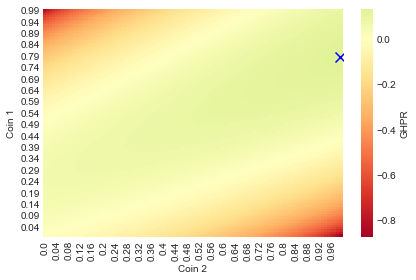

In [13]:
fig, ax = plt.subplots()
optimal_idx = f_two_coins_neg_corr['f_curve']['ghpr'].idxmax()
optimal_weights = f_two_coins_neg_corr['f_curve'].loc[optimal_idx, ['Coin 1', 'Coin 2']]
pivoted = pd.pivot_table(f_two_coins_neg_corr['f_curve'], values='ghpr', index='Coin 1', columns='Coin 2')
pivoted.sort_index(ascending=False, inplace=True)
pivoted.index = np.round(pivoted.index, 2)
pivoted.columns = np.round(pivoted.columns, 2)
sns.heatmap(pivoted, cmap='RdYlGn', center=0, ax=ax, cbar_kws={'label':'GHPR'})

# xvals = ax.get_xticklabels()
# ax.set_xticklabels(['{:,.2f}'.format(float(x)) for x in xvals])
# yvals = ax.get_yticklabels()
# ax.set_yticklabels(['{:,.2f}'.format(float(x)) for x in yvals])

# ax.imshow(pivoted)
# ax.scatter(optimal_weights[0], optimal_weights[1], marker='x', c='r')
ax.scatter(optimal_weights[1]*100, (1 - optimal_weights[0])*100, marker='x', c='b', s=100)
fig.tight_layout()
fig.savefig('Neg Correlated Coins Heatmap')

# Drawdown Constraints

## Helper Functions

In [20]:
def get_equity_curve(returns):
    equity_curve = (1 + returns).cumprod(axis=0)
    # Set the starting value of every curve to 1
    # normalized_eq = raw_eq / raw_eq[0]
    return equity_curve

def calc_twr(equity_curve, start_at_1=True):
    eq_arr = np.array(equity_curve)
    if start_at_1 == True:
        twr = eq_arr[-1] 
    else:
        twr = eq_arr[-1] / eq_arr[0]
    return twr

def calc_ghpr_eq(equity_curve):
    twr = calc_twr(equity_curve)
    ghpr_eq = twr ** (1 / len(equity_curve)) - 1
    return ghpr_eq

def calc_drawdown(equity_curve):
    eq_series = pd.DataFrame(equity_curve)
    drawdown = eq_series / eq_series.cummax() - 1
    return drawdown

def calc_max_drawdown(equity_curve, percent=True):
    abs_drawdown = np.abs(calc_drawdown(equity_curve)).values
    max_drawdown = np.max(abs_drawdown)
    if percent == True:
        return max_drawdown * 100
    else:
        return max_drawdown
    
def calc_ulcer_index(equity_curve):
    drawdown = calc_drawdown(equity_curve)
    ulcer_index = np.sqrt(np.mean(drawdown**2)) * 100
    return ulcer_index

def ideal_f_multiple(returns, time_horizon=250, n_curves=1000, 
                     drawdown_limit=20, certainty_level=95, steps=100, 
                     bound_factor=1):
    start = time.time()
    strategies = returns.columns
    potential_weights = weight_combinations(returns, steps, bound_factor)
    f_curve = pd.DataFrame()
    for i in range(len(potential_weights)):
        # Record weights
        weights = potential_weights[i]
        for j in range(len(strategies)):
            f_curve.loc[i, strategies[j]] = weights[j]
        weighted_returns = calc_weighted_returns(returns, weights)
            
        # Generate n random equity curves
        reordered_returns = np.random.choice(weighted_returns, size=(time_horizon, n_curves))
        curves = get_equity_curve(reordered_returns)
        curves_df = pd.DataFrame(curves)
        
        # Calculate GHPR and Maximum Drawdown for each equity curve
        curves_drawdown = calc_max_drawdown(curves_df)
        curves_ghpr = calc_ghpr_eq(curves_df)
        
        # Calculate drawdown at our certainty level
        drawdown_percentile = np.percentile(curves_drawdown, certainty_level)
        
        # Calculate median ghpr value
        ghpr_median = np.median(curves_ghpr)
        if drawdown_percentile <= drawdown_limit:
            ghpr = ghpr_median
        else:
            ghpr = 0
        f_curve.loc[i, 'ghpr'] = ghpr * 100
        f_curve.loc[i, 'drawdown'] = drawdown_percentile
    optimal_f = f_curve.loc[f_curve['ghpr'].idxmax()]
    elapsed = time.time() - start
    print('Ideal f calculated in {}s'.format(elapsed))
    
    return {'f_curve':f_curve, 'optimal_f':optimal_f}

## Load Data

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


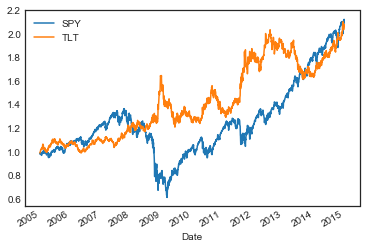

In [21]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

start_date = '2005-01-01'
end_date = '2015-01-01'

# Get returns for SPY and TLT
etf_returns = pd.DataFrame()
etfs = {}
for symbol in ['SPY', 'TLT']:
    df = pdr.get_data_yahoo(symbol, start=start_date, 
                            end=end_date, auto_adjust=True)
    etfs[symbol] = df
    etf_returns[symbol] = df['Close'].pct_change()
get_equity_curve(etf_returns).plot()

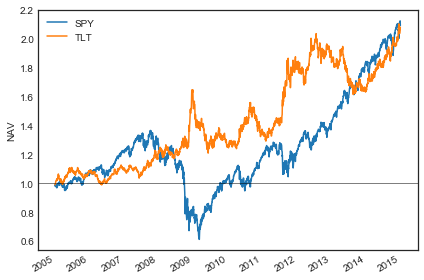

In [22]:
sns.set_style('white')
fig, ax = plt.subplots()
get_equity_curve(etf_returns).plot(ax=ax)
ax.axhline(1, c='k', linewidth=0.5)
ax.set_xlabel('')
ax.set_ylabel('NAV')
fig.tight_layout()
fig.savefig('SPY_TLT Buy_Hold Equity')

In [23]:
f_etfs_dd = ideal_f_multiple(etf_returns, bound_factor=4)
print(f_etfs_dd['optimal_f'])

Ideal f calculated in 104.5985779762268s
SPY          0.457094
TLT          0.495551
ghpr         0.032737
drawdown    19.833778
Name: 1810, dtype: float64


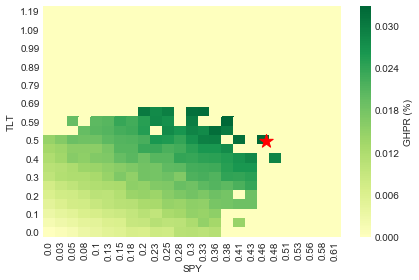

In [24]:
fig, ax = plt.subplots()
optimal_idx = f_etfs_dd['f_curve']['ghpr'].idxmax()
optimal_weights = f_etfs_dd['f_curve'].loc[optimal_idx, ['SPY', 'TLT']]

pivoted = pd.pivot_table(f_etfs_dd['f_curve'], values='ghpr', columns='SPY', index='TLT')
pivoted.sort_index(ascending=False, inplace=True)
pivoted.index = np.round(pivoted.index, 2)
pivoted.columns = np.round(pivoted.columns, 2)
pivoted = pivoted.iloc[-25:, :25]
optimal_x = optimal_weights[0] / pivoted.columns[-1] * 25
optimal_y = (1 - optimal_weights[1] / pivoted.index[0]) * 25

sns.heatmap(pivoted, cmap='RdYlGn', center=0, ax=ax, cbar_kws={'label':'GHPR (%)'})

ax.scatter(optimal_x, optimal_y, marker='*', c='red', s=200)
fig.tight_layout()
fig.savefig('ETF Returns Heatmap')

In [25]:
max_ghpr = f_etfs_dd['optimal_f']['ghpr']
(1 + max_ghpr/100)**252 - 1

0.08597973675489645

# Non-Linear Optimization

## Helper Functions

In [26]:
def sharpe_ratio(x):
    return np.mean(x) / np.std(x)

def rolling_z_score(series, lookback):
    mu = series.rolling(lookback).mean()
    sigma = series.rolling(lookback).mean()
    return (series - mu) / sigma

class Portfolio:
    
    def __init__(self, returns, regularized=False, c=1e-6):
        self.returns = returns
        self.regularized = regularized
        self.c = c
        
    def fitness_function(self, weights):
        weighted_returns = calc_weighted_returns(self.returns, weights)
        neg_sharpe_ratio = -1 * sharpe_ratio(weighted_returns)
        penalty = self.c * np.linalg.norm(weights, ord=1)
        if self.regularized:
            return neg_sharpe_ratio
        else:
            return neg_sharpe_ratio + penalty

    def optimize_portfolio(self, display=False):
        num_strategies = self.returns.shape[1]
        initial_guess = [0.5] * num_strategies
        optimization_results = cma.fmin(
                self.fitness_function, initial_guess, 0.25, 
                options={'bounds':[0,1], 'verb_disp':display, 'tolfun':0.0001}
        )
        return optimization_results[0]

## Create Strategies

In [27]:
strategies = pd.DataFrame(index=etf_returns.index)
strategy_returns = pd.DataFrame(index=etf_returns.index)

spy = etfs['SPY']
spy_returns = spy['Open'].pct_change().shift(-2)
strategies['SPY_5'] = rolling_z_score(spy['Close'], 5, 20) * -1
strategies['SPY_50'] = rolling_z_score(spy['Close'], 50, 20)
strategies['SPY_100'] = rolling_z_score(spy['Close'], 100, 20)

tlt = etfs['TLT']
tlt_returns = tlt['Open'].pct_change().shift(-2)
strategies['TLT_5'] = rolling_z_score(tlt['Close'], 5, 20) * -1
strategies['TLT_50'] = rolling_z_score(tlt['Close'], 50, 20)
strategies['TLT_100'] = rolling_z_score(tlt['Close'], 100, 20)

for column in strategies.columns:
    symbol = column[:3]
    if symbol == 'SPY':
        strategy_returns[column] = strategies[column].multiply(spy_returns)
    elif symbol == 'TLT':
        strategy_returns[column] = strategies[column].multiply(tlt_returns)

TypeError: rolling_z_score() takes 2 positional arguments but 3 were given

## Optimize Portfolio

In [ ]:
portfolio = Portfolio(strategy_returns)
results = portfolio.optimize_portfolio()
optimal_weights = pd.DataFrame(np.round(results, 2), index=strategy_returns.columns, columns=[''])
optimal_weights

## Determine Leverage

In [ ]:
def ideal_f(returns, time_horizon=250, n_curves=5000, drawdown_limit=20, certainty_level=95, steps=200):    
    
    start = time.time()
    f_values = np.linspace(0, 0.99, steps)
    max_loss = np.abs(np.min(returns))
    bounded_f = f_values / max_loss
    f_curve = pd.DataFrame(columns=['ghpr', 'drawdown'])    
    for f in bounded_f:
        # Generate n_curves number of random equity curves
        reordered_returns = np.random.choice(f * returns, size=(time_horizon, n_curves))
        curves = get_equity_curve(reordered_returns)
        curves_df = pd.DataFrame(curves)        
        # Calculate GHPR and Maximum Drawdown for each equity curve
        curves_drawdown = calc_max_drawdown(curves_df)
        curves_ghpr = calc_ghpr_eq(curves_df) 
        # Calculate drawdown at our certainty level
        drawdown_percentile = np.percentile(curves_drawdown, certainty_level)
        # Calculate median ghpr value
        ghpr_median = np.median(curves_ghpr)
        if drawdown_percentile <= drawdown_limit:
            ghpr = ghpr_median
        else:
            ghpr = 0
        f_curve.loc[f, 'ghpr'] = ghpr * 100
        f_curve.loc[f, 'drawdown'] = drawdown_percentile
    optimal_f = f_curve['ghpr'].idxmax()
    
    elapsed = time.time() - start
    print('Ideal f calculated in {}s'.format(elapsed))
    
    return {'f_curve':f_curve, 'optimal_f':optimal_f, 'max_loss':max_loss}

In [ ]:
optimal_returns = calc_weighted_returns(strategy_returns, results)
leverage = ideal_f(optimal_returns)['optimal_f']
print(leverage)

In [ ]:
leveraged_weights = optimal_weights.multiply(leverage)
leveraged_returns = calc_weighted_returns(strategy_returns, leveraged_weights.values.flatten())
np.round(leveraged_weights, 2)

## Plot Performance

In [ ]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 1, figsize=(7,7), sharex=True)

eq = get_equity_curve(leveraged_returns)
dd = calc_drawdown(eq)

eq.plot(ax=axes[0])
axes[0].axhline(1, c='k', linewidth=0.5)
axes[0].set_ylabel('NAV')

dd.plot(kind='area', ax=axes[1])
axes[1].set_ylabel('Drawdown')
vals1 = axes[1].get_yticks()
axes[1].set_yticklabels(['{:,.2%}'.format(x) for x in vals1])
axes[1].get_legend().remove()
fig.tight_layout()
fig.savefig('Leveraged Portfolio Equity Curve')